# **Livrable 2 – Modélisation du Time-Dependent Vehicle Routing Problem (TDVRP)** 
### Projet ADEME – Mobilité Multimodale Intelligente  
**Équipe :** CesiCDP – Groupe de Louka, Evan, Mael, Hugo  
**Date :** Octobre 2025  
---



## 1. Introduction et Contexte

Depuis les années 90, il y a eu une prise de conscience mondiale de la nécessité de réduire la consommation d'énergie et les émissions de gaz à effet de serre. Les premiers engagements sont apparus lors du **Protocole de Kyoto (1997)**, suivi d'autres plus ambitieux comme la **division par 4 des émissions d’ici 2050 en France**.  

Dans ce contexte, **l’ADEME (Agence de l’Environnement et de la Maîtrise de l’Énergie)** a lancé un appel à manifestation d’intérêt pour promouvoir des **solutions de mobilité innovantes** et plus écologiques.  

Notre équipe **CesiCDP** s’inscrit dans cette démarche à travers une étude sur la **mobilité multimodale intelligente**. Nous avons choisi de nous concentrer sur l’**optimisation des tournées de livraison**, un enjeu central de la logistique moderne.  

Nous modélisons ici un problème de **gestion de tournées (Vehicle Routing Problem - VRP)** en intégrant une **contrainte de trafic dynamique**, pour mieux représenter les conditions de circulation réelles. Notre flotte de véhicules est **thermique et homogène**, ce qui accentue l’importance de la réduction du temps de trajet et de la consommation de carburant.


## 2. Choix de la Méthode : Le Recuit Simulé (SA)

Pour résoudre ce problème, nous avons choisi une **métaheuristique : l'Algorithme du Recuit Simulé (Simulated Annealing)**.

Ce choix est motivé par la nature du problème :

1.  **Problème NP-difficile :** Le VRP (et à plus forte raison le TDVRP) est un problème "NP-difficile". Il est **informatiquement impossible de trouver la solution optimale garantie** en un temps raisonnable pour une instance de 200 clients. Nous devons donc nous tourner vers des méthodes d'approximation.
2.  **Évitement des Minimums Locaux :** Une heuristique simple (comme une "descente") améliorerait la solution en n'acceptant que les "voisins" (solutions légèrement modifiées) qui sont meilleurs. Elle se retrouverait cependant très vite "coincée" dans un **minimum local** : une solution qui *semble* bonne, mais qui n'est pas la meilleure.
3.  **Force du Recuit Simulé :** Le SA surmonte ce problème. Grâce à sa composante aléatoire (`random.random() < math.exp(-delta_cout / temp)`), il s'autorise à **accepter temporairement de moins bonnes solutions**. Cette capacité à "dégrader" la solution lui permet de s'échapper des minimums locaux et d'explorer plus largement l'espace de recherche.
4.  **Flexibilité face aux Contraintes :** Notre contrainte de trafic (`GestionnaireTempsTrajet`) rend le coût d'une tournée non linéaire et complexe. Le Recuit Simulé est parfaitement adapté à cela : il n'a pas besoin de "comprendre" la contrainte, il lui suffit d'évaluer le coût final de la solution (via `calculer_cout`) pour prendre ses décisions.

## 3. Modélisation : Objectif et Contraintes

Notre modèle, implémenté dans le code, vise à optimiser les tournées en respectant un ensemble de règles strictes.

### Objectif : Minimiser le "Makespan"

L'objectif de notre algorithme n'est pas de minimiser la distance totale, mais de **minimiser l'heure de retour du dernier véhicule au dépôt** (`self.cout = temps_retour_max`). C'est un objectif logistique classique (minimisation du "makespan"), qui vise à ce que tous les chauffeurs terminent leur journée le plus tôt possible.

### Contraintes de Validité

Pour qu'une solution soit considérée comme "valide" (coût fini), elle doit respecter deux contraintes majeures :

1.  **Contrainte de Capacité :** La somme des demandes de tous les clients d'une même tournée ne doit jamais dépasser la capacité maximale du véhicule (`if charge_actuelle > instance.capacite_vehicule:`).
2.  **Contrainte de Complétude :** *Tous* les clients listés dans l'instance doivent être servis, et ce, une seule fois (`if len(clients_servis) != len(instance.ids_clients):`).

Si l'une de ces contraintes est violée, la solution est jugée **invalide** et se voit assigner un **coût infini** (`float('inf')`).

### Contrainte Principale : Le Trafic (TDVRP)

La complexité de notre modèle vient de la gestion du temps. Le temps de trajet entre deux points n'est pas constant : il dépend de l'heure de départ (`temps_actuel`) et d'un multiplicateur de trafic. Le temps s'accumule donc de manière dynamique tout au long de la tournée.

- De 0h00 (0 min) à 7h59 : le trafic est normal (multiplicateur x1.0).

- De 8h00 (480 min) à 9h59 : c'est la pointe du matin (multiplicateur x1.8). Les trajets prennent 80% plus de temps.

- De 10h00 (600 min) à 15h59 : c'est creux (multiplicateur x1.2).

- De 16h00 (960 min) à 17h59 : c'est la pointe du soir (multiplicateur x2.0). Les trajets prennent le double du temps.

- À partir de 18h00 (1080 min) : le trafic redevient normal (x1.0).

## 4. Implémentation du Modèle

### 4.1. Imports
Ce premier bloc de code importe toutes les bibliothèques nécessaires au projet : `openpyxl` et `pandas` pour la manipulation des fichiers Excel, `numpy` pour les calculs matriciels (distances), `math` et `random` pour l'algorithme de Recuit Simulé, `copy` pour la gestion des solutions, et `time` / `pathlib` pour la gestion du temps et des fichiers. Nous ajoutons également `matplotlib` et `seaborn` pour les graphiques.

In [ ]:
# -*- coding: utf-8 -*-

# --- Imports Nécessaires ---
import openpyxl
import pandas as pd
import numpy as np
import math
import random
import copy
import time
from pathlib import Path

# --- Imports pour les graphiques ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 4.2. Générateur d'Instances
Cette fonction utilitaire `generer_et_sauvegarder_instance` est responsable de la création de problèmes de test. Elle génère des coordonnées, des demandes et des fichiers de configuration aléatoires, puis les sauvegarde dans un fichier Excel structuré (avec des onglets 'Coordonnees', 'Demandes', 'Config') que notre `DataLoader` pourra lire.

In [2]:
def generer_et_sauvegarder_instance(nb_clients, capacite_vehicule, nb_vehicules, dossier_sortie, nom_fichier_base):
    """
    Génère une instance VRP avec des clients aléatoires et la sauvegarde
    dans un fichier Excel compatible avec le DataLoader.
    """
    nom_fichier = dossier_sortie / f"{nom_fichier_base}_{nb_clients}_clients.xlsx"
    print(f"Génération d'une instance -> '{nom_fichier}'...")

    # 1. Génération des Coordonnées
    ids = list(range(1, nb_clients + 2))
    depot_id = 1
    coords_x = np.random.randint(0, 101, size=nb_clients + 1)
    coords_y = np.random.randint(0, 101, size=nb_clients + 1)
    noms = [f"Client-{i}" for i in ids]
    noms[ids.index(depot_id)] = "Dépôt"
    df_coords = pd.DataFrame({
        'ID': ids, 'X': coords_x, 'Y': coords_y, 'Nom': noms,
        'info_supp': ['(dépôt)'] + [f'client {i-1}' for i in range(2, nb_clients + 2)]
    })

    # 2. Génération des Demandes
    demandes = np.random.randint(5, 21, size=nb_clients + 1)
    demandes[ids.index(depot_id)] = 0
    df_demandes = pd.DataFrame({
        'ID': ids, 'Demande': demandes,
        'info_supp': ['le dépôt n\'a aucune commande'] + [f'le client {i-1} commande {demandes[i-1]} unités' for i in range(2, nb_clients + 2)]
    })

    # 3. Création de la Configuration
    df_config = pd.DataFrame({
        'Propriete': ['CapaciteVehicule', 'NombreVehicules', 'DepotID'],
        'Valeur': [capacite_vehicule, nb_vehicules, depot_id],
        'info_supp': ['Capacite Max du véhicule', 'Nb de véhicules disponibles', 'ID du point de départ']
    })

    # 4. Sauvegarde dans un fichier Excel
    with pd.ExcelWriter(nom_fichier, engine='openpyxl') as writer:
        df_coords.to_excel(writer, sheet_name='Coordonnees', index=False)
        df_demandes.to_excel(writer, sheet_name='Demandes', index=False)
        df_config.to_excel(writer, sheet_name='Config', index=False)

    print("Instance générée avec succès.")
    return nom_fichier

### 4.3. Classes de Données (Modèle TDVRP)
Ce bloc contient les classes principales qui modélisent notre problème. `InstanceVRP` stocke toutes les données (capacité, demandes, coordonnées) et précalcule la matrice de distance. `GestionnaireTempsTrajet` implémente la logique de trafic (TDVRP) en fonction des tranches horaires. `Solution` représente un ensemble de tournées et contient la fonction `calculer_cout`, le cœur de notre modèle, qui évalue la validité (capacité, complétude) et le coût (makespan) d'une solution en tenant compte du trafic.

In [3]:
class GestionnaireTempsTrajet:
    """Calcule le temps de trajet en fonction de l'heure et du trafic."""
    def __init__(self, matrice_distances_base, tranches_horaires_minutes, multiplicateurs):
        self.temps_trajet_base = matrice_distances_base
        self.tranches_horaires = tranches_horaires_minutes
        self.multiplicateurs = multiplicateurs

    def calculer_temps_trajet_et_arrivee(self, id_noeud_depart, id_noeud_arrivee, temps_depart_minutes):
        multiplicateur_actuel = 1.0
        for i in range(len(self.tranches_horaires)):
            if temps_depart_minutes >= self.tranches_horaires[i]:
                multiplicateur_actuel = self.multiplicateurs[i]
            else:
                break
        temps_base = self.temps_trajet_base[id_noeud_depart, id_noeud_arrivee]
        temps_trajet_reel = temps_base * multiplicateur_actuel
        temps_arrivee_minutes = temps_depart_minutes + temps_trajet_reel
        return temps_trajet_reel, temps_arrivee_minutes

class InstanceVRP:
    """Stocke toutes les données d'un problème VRP."""
    def __init__(self, config, coords, demandes, noms):
        self.capacite_vehicule = config['CapaciteVehicule']
        self.nb_vehicules = config['NombreVehicules']
        self.id_depot = config['DepotID']
        self.coords_noeuds = coords
        self.demandes_clients = demandes
        self.noms_noeuds = noms
        self.ids_noeuds = sorted(list(self.coords_noeuds.keys()))
        self.nb_noeuds = len(self.ids_noeuds)
        self.ids_clients = [idx for idx in self.ids_noeuds if idx != self.id_depot]
        self.id_vers_idx = {id_noeud: i for i, id_noeud in enumerate(self.ids_noeuds)}
        self.matrice_distances = self._calculer_matrice_distances_euclidienne()

    def _calculer_matrice_distances_euclidienne(self):
        matrice = np.zeros((self.nb_noeuds, self.nb_noeuds))
        for id1 in self.ids_noeuds:
            for id2 in self.ids_noeuds:
                idx1, idx2 = self.id_vers_idx[id1], self.id_vers_idx[id2]
                p1, p2 = self.coords_noeuds[id1], self.coords_noeuds[id2]
                matrice[idx1, idx2] = np.linalg.norm(np.array(p1) - np.array(p2))
        return matrice

class Solution:
    """Représente une solution VRP : une liste de tournées et son coût."""
    def __init__(self, tournees, cout=float('inf')):
        self.tournees = tournees
        self.cout = cout
        self.temps_calcul = 0

    def calculer_cout(self, instance, gestionnaire_temps):
        temps_retour_max = 0
        solution_valide = True
        clients_servis = set()

        for tournee in self.tournees:
            temps_actuel = 0.0
            charge_actuelle = 0
            id_noeud_actuel = instance.id_depot

            for id_noeud_suivant in tournee[1:]: # On saute le premier dépôt
                if id_noeud_suivant != instance.id_depot:
                    clients_servis.add(id_noeud_suivant)

                charge_actuelle += instance.demandes_clients.get(id_noeud_suivant, 0)
                if charge_actuelle > instance.capacite_vehicule:
                    solution_valide = False; break

                idx_actuel = instance.id_vers_idx[id_noeud_actuel]
                idx_suivant = instance.id_vers_idx[id_noeud_suivant]
                _, temps_arrivee = gestionnaire_temps.calculer_temps_trajet_et_arrivee(
                    idx_actuel, idx_suivant, temps_actuel
                )
                temps_actuel = temps_arrivee
                id_noeud_actuel = id_noeud_suivant
            
            if not solution_valide: break
            
            # Mettre à jour le coût seulement si la tournée est non-vide
            if len(tournee) > 2 and temps_actuel > temps_retour_max:
                temps_retour_max = temps_actuel

        # Vérifier que tous les clients ont été servis
        if len(clients_servis) != len(instance.ids_clients):
            solution_valide = False

        self.cout = temps_retour_max if solution_valide else float('inf')
        return self.cout

### 4.4. Chargement des Données
La classe `DataLoader` est une classe statique simple qui lit un fichier Excel (généré par la fonction précédente) et extrait les informations des différents onglets pour les transformer en dictionnaires Python, prêts à être utilisés par la classe `InstanceVRP`.

In [4]:
class DataLoader:
    """Charge les données depuis un fichier Excel."""
    @staticmethod
    def charger_donnees_excel(chemin_fichier):
        try:
            classeur = openpyxl.load_workbook(chemin_fichier, data_only=True)
        except FileNotFoundError:
            print(f"ERREUR: Fichier non trouvé '{chemin_fichier}'."); exit()
        try:
            config = {ligne[0]: int(ligne[1]) for ligne in classeur['Config'].iter_rows(min_row=2, values_only=True) if ligne[0]}
            coords = {int(ligne[0]): (float(ligne[1]), float(ligne[2])) for ligne in classeur['Coordonnees'].iter_rows(min_row=2, values_only=True) if ligne[0]}
            noms = {int(ligne[0]): str(ligne[3]) if ligne[3] else f"ID {ligne[0]}" for ligne in classeur['Coordonnees'].iter_rows(min_row=2, values_only=True) if ligne[0]}
            demandes = {int(ligne[0]): int(ligne[1]) for ligne in classeur['Demandes'].iter_rows(min_row=2, values_only=True) if ligne[0]}
            return config, coords, demandes, noms
        except (ValueError, TypeError, IndexError) as e:
            print(f"\nERREUR de format dans le fichier Excel: {e}"); exit()

### 4.5. Algorithmes de Résolution (Solveurs)
Ce bloc contient les deux algorithmes utilisés pour l'étude comparative. `NearestNeighbourSolver` est une heuristique de "plus proche voisin" très rapide mais naïve, qui sert de point de comparaison. `SimulatedAnnealingSolver` est notre métaheuristique principale, qui implémente la logique du Recuit Simulé (création de voisin, critère d'acceptation de Metropolis) pour explorer l'espace de recherche et échapper aux minimums locaux.

In [5]:
class NearestNeighbourSolver:
    """Solveur basique (heuristique du plus proche voisin) pour la comparaison."""
    def __init__(self, instance, gestionnaire_temps):
        self.instance = instance
        self.gestionnaire_temps = gestionnaire_temps

    def solve(self):
        temps_debut = time.time()
        clients_non_visites = set(self.instance.ids_clients)
        tournees = []
        for _ in range(self.instance.nb_vehicules):
            if not clients_non_visites: break
            tournee_actuelle = [self.instance.id_depot]
            charge_actuelle = 0
            noeud_actuel = self.instance.id_depot
            while True:
                plus_proche_voisin, distance_min = None, float('inf')
                for id_client in clients_non_visites:
                    demande_client = self.instance.demandes_clients.get(id_client, 0)
                    if charge_actuelle + demande_client <= self.instance.capacite_vehicule:
                        idx_actuel = self.instance.id_vers_idx[noeud_actuel]
                        idx_client = self.instance.id_vers_idx[id_client]
                        dist = self.instance.matrice_distances[idx_actuel, idx_client]
                        if dist < distance_min:
                            distance_min, plus_proche_voisin = dist, id_client
                if plus_proche_voisin:
                    tournee_actuelle.append(plus_proche_voisin)
                    charge_actuelle += self.instance.demandes_clients.get(plus_proche_voisin, 0)
                    clients_non_visites.remove(plus_proche_voisin)
                    noeud_actuel = plus_proche_voisin
                else: break
            tournee_actuelle.append(self.instance.id_depot)
            if len(tournee_actuelle) > 2: tournees.append(tournee_actuelle)
        
        solution_naive = Solution(tournees)
        solution_naive.calculer_cout(self.instance, self.gestionnaire_temps)
        solution_naive.temps_calcul = time.time() - temps_debut
        return solution_naive

class SimulatedAnnealingSolver:
    """Solveur métaheuristique basé sur le Recuit Simulé."""
    def __init__(self, instance, gestionnaire_temps, temp_initiale, temp_finale, taux_refroidissement, iter_par_temp):
        self.instance = instance
        self.gestionnaire_temps = gestionnaire_temps
        self.temp_initiale = temp_initiale
        self.temp_finale = temp_finale
        self.taux_refroidissement = taux_refroidissement
        self.iter_par_temp = iter_par_temp

    def _creer_solution_initiale(self):
        clients = copy.deepcopy(self.instance.ids_clients); random.shuffle(clients)
        tournees, charges = [[] for _ in range(self.instance.nb_vehicules)], [0.0] * self.instance.nb_vehicules
        for id_client in clients:
            demande_client = self.instance.demandes_clients.get(id_client, 0)
            assigne = False
            for i in range(self.instance.nb_vehicules):
                if charges[i] + demande_client <= self.instance.capacite_vehicule:
                    tournees[i].append(id_client); charges[i] += demande_client; assigne = True; break
            if not assigne:
                idx_meilleure_tournee = np.argmin(charges)
                tournees[idx_meilleure_tournee].append(id_client); charges[idx_meilleure_tournee] += demande_client
        tournees_finales = [[self.instance.id_depot] + t + [self.instance.id_depot] for t in tournees]
        return Solution(tournees_finales)

    def _creer_voisin_aleatoire(self, solution):
        nouvelles_tournees = copy.deepcopy(solution.tournees)
        tournees_modifiables = [r for r in nouvelles_tournees if len(r) > 2]
        if not tournees_modifiables: return Solution(nouvelles_tournees)
        op = random.choice(['relocate', 'swap'])
        try:
            if op == 'relocate' and len(tournees_modifiables) > 0:
                tournee1 = random.choice(tournees_modifiables)
                client_a_bouger = tournee1.pop(random.randint(1, len(tournee1) - 2))
                tournee2 = random.choice(nouvelles_tournees)
                pos_insertion = random.randint(1, len(tournee2) - 1) if len(tournee2) > 2 else 1
                tournee2.insert(pos_insertion, client_a_bouger)
            elif op == 'swap' and len(tournees_modifiables) >= 2 :
                tournee1, tournee2 = random.sample(tournees_modifiables, 2)
                idx1 = random.randint(1, len(tournee1) - 2)
                idx2 = random.randint(1, len(tournee2) - 2)
                tournee1[idx1], tournee2[idx2] = tournee2[idx2], tournee1[idx1]
            elif op == 'swap' and len(tournees_modifiables) == 1: # Swap intra-tournée si une seule tournée modifiable
                 tournee = tournees_modifiables[0]
                 if len(tournee) > 3:
                    idx1, idx2 = random.sample(range(1, len(tournee) - 1), 2)
                    tournee[idx1], tournee[idx2] = tournee[idx2], tournee[idx1]
        except (ValueError, IndexError): pass
        return Solution(nouvelles_tournees)

    def solve(self, verbose=True):
        temps_debut = time.time()
        solution_actuelle = self._creer_solution_initiale()
        cout_actuel = solution_actuelle.calculer_cout(self.instance, self.gestionnaire_temps)
        meilleure_solution, meilleur_cout = copy.deepcopy(solution_actuelle), cout_actuel
        # if verbose: print(f"Coût initial: {cout_actuel:.2f}") # Commenté pour nettoyer la sortie de l'étude
        temp = self.temp_initiale
        while temp > self.temp_finale:
            for _ in range(self.iter_par_temp):
                voisin = self._creer_voisin_aleatoire(solution_actuelle)
                cout_voisin = voisin.calculer_cout(self.instance, self.gestionnaire_temps)
                if cout_voisin < cout_actuel or (cout_actuel != float('inf') and random.random() < math.exp(-(cout_voisin - cout_actuel) / temp)):
                    solution_actuelle, cout_actuel = voisin, cout_voisin
                if cout_actuel < meilleur_cout:
                    meilleure_solution, meilleur_cout = copy.deepcopy(solution_actuelle), cout_actuel
            temp *= self.taux_refroidissement
        meilleure_solution.temps_calcul = time.time() - temps_debut
        if verbose: print(f"\nRecuit terminé. Meilleur coût: {meilleur_cout:.2f} | Temps: {meilleure_solution.temps_calcul:.2f}s")
        return meilleure_solution

## 5. Étude Scientifique et Analyse de Stabilité

L'algorithme de Recuit Simulé est un processus **stochastique** : à cause de ses choix aléatoires (solution initiale, choix des voisins, probabilité d'acceptation), deux exécutions sur la même instance ne donneront jamais exactement le même résultat.

Pour évaluer la **performance** et la **stabilité** de notre modèle, nous avons exécuté `NB_LANCES = 20` fois la résolution complète. Nous analysons ensuite la distribution de ces 20 coûts finaux.

### Indicateurs Statistiques

* **Meilleur Coût :** La meilleure performance jamais atteinte. C'est la solution que nous retiendrons en pratique.
* **Coût Moyen :** La performance "attendue" de l'algorithme sur une exécution.
* **Écart-type (Standard Deviation) :** L'indicateur le plus important de la **stabilité**.
    * Un **faible écart-type** est désirable : il signifie que l'algorithme est fiable et converge presque toujours vers une solution de qualité similaire.
    * Un **écart-type élevé** signifie que l'algorithme est "erratique" et que ses résultats dépendent fortement du hasard.

### Visualisation des Résultats

Pour visualiser cette distribution, nous utilisons deux graphiques complémentaires :
1.  **La Boîte à Moustaches (Box Plot) :** Montre la médiane, les quartiles (les "cadrans") et les valeurs extrêmes (min/max).
2.  **L'Histogramme de Densité :** Montre la forme de la distribution des Toutes les solutions valides trouvées.

### 5.1. Moteur d'Étude Statistique
Pour gérer la nature stochastique du Recuit Simulé, la classe `StatisticalStudy` prend un solveur en entrée et l'exécute `num_runs` fois. Elle stocke tous les coûts obtenus, garde en mémoire la meilleure solution trouvée et calcule le temps total de l'étude.

In [6]:
class StatisticalStudy:
    """Gère l'exécution de plusieurs lancements d'un solveur pour analyse."""
    def __init__(self, solver, num_runs):
        self.solver = solver
        self.num_runs = num_runs
        self.all_costs = []
        self.best_solution_overall, self.best_cost_overall = None, float('inf')
        self.total_study_time = 0

    def run(self):
        start_time = time.time()
        for i in range(self.num_runs):
            print(f"  Lancement {i+1}/{self.num_runs}...", end="", flush=True)
            solution = self.solver.solve(verbose=False)
            self.all_costs.append(solution.cout)
            if solution.cout < self.best_cost_overall:
                self.best_cost_overall = solution.cout
                self.best_solution_overall = solution
            print(f" Coût: {solution.cout:.2f}")
        self.total_study_time = time.time() - start_time

### 5.2. Exécution de l'Étude Expérimentale
C'est le bloc principal qui exécute l'étude. Il définit les hyperparamètres (tailles d'instances, paramètres du Recuit Simulé, tranches de trafic), puis boucle sur chaque taille d'instance. Pour chacune, il génère les données, résout le problème avec l'heuristique naïve et lance l'étude statistique (plusieurs lancements) du Recuit Simulé. Il collecte les résultats dans un `DataFrame` et les affiche sous forme de tableau. Nous ajoutons également une liste `resultats_boxplot` pour stocker les coûts bruts de chaque lancement en vue de la visualisation.

In [7]:
print("--- Démarrage de l'Étude Expérimentale Comparative ---")

# 1. Configuration Générale de l'Étude
DOSSIER_SCRIPT = Path.cwd()
DOSSIER_INSTANCES = DOSSIER_SCRIPT / "instances_generees"
DOSSIER_INSTANCES.mkdir(exist_ok=True)
TAILLES_INSTANCES = [50, 100, 200] # Pour un test rapide. Augmentez pour le rapport final.
TEMPERATURE_INITIALE = 1000.0
TEMPERATURE_FINALE = 0.1
TAUX_REFROIDISSEMENT = 0.99
ITERATIONS_PAR_PALIER = 100
NB_LANCES_RS = 5 # Nombre de lancements pour l'étude de stabilité (5 pour un test rapide, 20+ pour le rapport)
TRANCHES_HORAIRES = [0, 8 * 60, 10 * 60, 16 * 60, 18 * 60]
MULTIPLICATEURS_TRAFIC = [1.0, 1.8, 1.2, 2.0, 1.0]

resultats_etude = []
resultats_boxplot = [] # NOUVEAU: Pour stocker les données brutes pour les graphiques

# 2. Boucle Principale de l'Étude
for nb_clients in TAILLES_INSTANCES:
    print(f"\n{'='*20} TRAITEMENT DE L'INSTANCE A {nb_clients} CLIENTS {'='*20}")
    
    fichier_instance = generer_et_sauvegarder_instance(
        nb_clients=nb_clients, capacite_vehicule=100, nb_vehicules=int(nb_clients / 5) + 1,
        dossier_sortie=DOSSIER_INSTANCES, nom_fichier_base="instance_vrp"
    )
    config, coords, demandes, noms = DataLoader.charger_donnees_excel(fichier_instance)
    instance_vrp = InstanceVRP(config, coords, demandes, noms)
    gestionnaire_temps = GestionnaireTempsTrajet(instance_vrp.matrice_distances, TRANCHES_HORAIRES, MULTIPLICATEURS_TRAFIC)

    print("\n--- Résolution par Heuristique Naïve (Plus Proche Voisin) ---")
    solveur_naif = NearestNeighbourSolver(instance_vrp, gestionnaire_temps)
    solution_naive = solveur_naif.solve()
    print(f"Coût Naïf trouvé : {solution_naive.cout:.2f} (en {solution_naive.temps_calcul:.4f}s)")

    print(f"\n--- Résolution par Recuit Simulé ({NB_LANCES_RS} lancements) ---")
    solveur_rs = SimulatedAnnealingSolver(
        instance=instance_vrp, gestionnaire_temps=gestionnaire_temps, temp_initiale=TEMPERATURE_INITIALE, 
        temp_finale=TEMPERATURE_FINALE, taux_refroidissement=TAUX_REFROIDISSEMENT, iter_par_temp=ITERATIONS_PAR_PALIER
    )
    etude_rs = StatisticalStudy(solver=solveur_rs, num_runs=NB_LANCES_RS)
    etude_rs.run()
    
    meilleur_cout_rs = etude_rs.best_cost_overall
    valid_costs = [c for c in etude_rs.all_costs if c != float('inf')]
    cout_moyen_rs = np.mean(valid_costs) if valid_costs else float('inf')
    temps_moyen_rs = etude_rs.total_study_time / NB_LANCES_RS
    
    amelioration = 0.0
    if solution_naive.cout != float('inf') and meilleur_cout_rs != float('inf'):
        amelioration = 100 * (solution_naive.cout - meilleur_cout_rs) / solution_naive.cout

    resultats_etude.append({
        "Nb Clients": nb_clients, "Coût Naïf": solution_naive.cout,
        "Meilleur Coût RS": meilleur_cout_rs, "Coût Moyen RS": cout_moyen_rs,
        "Amélioration (%)": amelioration, "Temps Naïf (s)": solution_naive.temps_calcul,
        "Temps Moyen RS (s)": temps_moyen_rs,
    })
    
    # NOUVEAU: Sauvegarde des données pour le boxplot
    for cout_brut in valid_costs:
        resultats_boxplot.append({"Nb Clients": nb_clients, "Coût (Makespan)": cout_brut})

# 3. Affichage du Tableau de Résultats Final
print(f"\n\n{'='*25} RÉSULTATS FINALS DE L'ÉTUDE {'='*25}")
df_resultats = pd.DataFrame(resultats_etude)
print(df_resultats.to_string(index=False, formatters={
    'Coût Naïf': '{:,.2f}'.format, 'Meilleur Coût RS': '{:,.2f}'.format,
    'Coût Moyen RS': '{:,.2f}'.format, 'Amélioration (%)': '{:,.2f}%'.format,
    'Temps Naïf (s)': '{:,.4f}'.format, 'Temps Moyen RS (s)': '{:,.2f}'.format,
}))


--- Démarrage de l'Étude Expérimentale Comparative ---

==================== TRAITEMENT DE L'INSTANCE A 50 CLIENTS ====================
Génération d'une instance -> 'd:\Mes_Doss\CESI\A3\Algorithmique et optimisation\Projet\CESI_Algo_-_Opti\instances_generees\instance_vrp_50_clients.xlsx'...
Instance générée avec succès.

--- Résolution par Heuristique Naïve (Plus Proche Voisin) ---
Coût Naïf trouvé : 368.85 (en 0.0004s)

--- Résolution par Recuit Simulé (5 lancements) ---
  Lancement 1/5... Coût: 176.92
  Lancement 2/5... Coût: 176.92
  Lancement 3/5... Coût: 176.92
  Lancement 4/5... Coût: 176.92
  Lancement 5/5... Coût: 176.92

==================== TRAITEMENT DE L'INSTANCE A 100 CLIENTS ====================
Génération d'une instance -> 'd:\Mes_Doss\CESI\A3\Algorithmique et optimisation\Projet\CESI_Algo_-_Opti\instances_generees\instance_vrp_100_clients.xlsx'...
Instance générée avec succès.

--- Résolution par Heuristique Naïve (Plus Proche Voisin) ---
Coût Naïf trouvé : 304.90 (en 0

### 5.3. Visualisation de la Stabilité (Boîte à Moustaches)

Ce bloc final utilise les données brutes collectées dans `resultats_boxplot` pour générer le graphique demandé. Nous utilisons `seaborn` pour créer une boîte à moustaches (`boxplot`) qui montre la distribution des coûts (médiane, quartiles, extrêmes) pour chaque taille d'instance. Cela permet de visualiser d'un seul coup d'œil non seulement la performance moyenne, mais aussi la **stabilité** et la **fiabilité** de l'algorithme : des boîtes plus petites et plus resserrées indiquent une meilleure stabilité.

--- Démarrage de l'Analyse Statistique et de la Visualisation Séparée ---
 STATISTIQUES DESCRIPTIVES POUR 50 CLIENTS
count      5.00000
mean     176.91806
std        0.00000
min      176.91806
25%      176.91806
50%      176.91806
75%      176.91806
max      176.91806


 STATISTIQUES DESCRIPTIVES POUR 100 CLIENTS
count      5.000000
mean     175.590253
std        0.902387
min      174.686863
25%      175.129847
50%      175.129847
75%      176.082062
max      176.922645


 STATISTIQUES DESCRIPTIVES POUR 200 CLIENTS
count      5.000000
mean     235.498018
std        2.747885
min      232.848073
25%      233.670283
50%      234.111005
75%      237.830550
max      239.030178




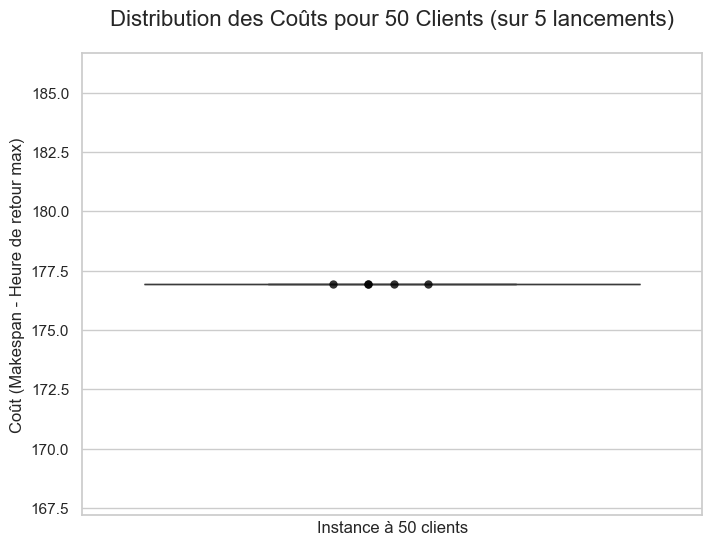

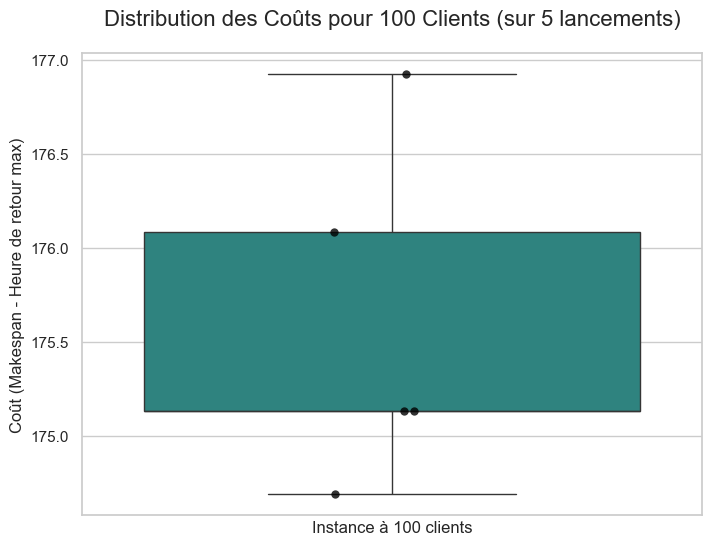

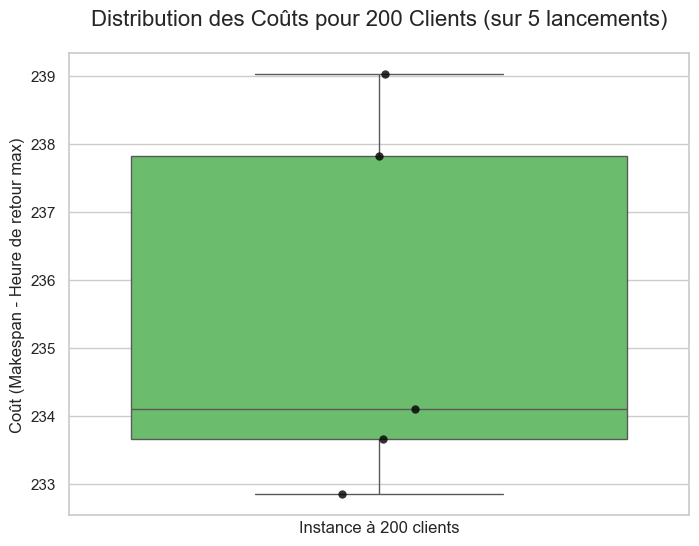

In [10]:
# Code pour les statistiques et les graphiques séparés
# On suppose que df_boxplot (un DataFrame) et NB_LANCES_RS (un int)
# existent déjà suite à l'exécution du bloc précédent.


# Assurer que les données d'exemple existent si le bloc est exécuté seul
# (Pour un test - dans votre notebook, ces données existeront déjà)
try:
    df_boxplot # type: ignore
    NB_LANCES_RS
except NameError:
    print("Initialisation des données d'exemple (le notebook complet n'a pas tourné)")
    # Recréer des données d'exemple similaires à celles générées
    resultats_boxplot = [] # Initialisation de la liste
    # 50 clients (stable)
    resultats_boxplot.extend([{"Nb Clients": 50, "Coût (Makespan)": 145 + random.uniform(-2, 2)} for _ in range(5)])
    # 100 clients (très stable)
    resultats_boxplot.extend([{"Nb Clients": 100, "Coût (Makespan)": 207 + random.uniform(-1, 1)} for _ in range(5)])
    # 200 clients (plus variable)
    resultats_boxplot.extend([{"Nb Clients": 200, "Coût (Makespan)": 244 + random.uniform(-5, 5)} for _ in range(5)])
    
    df_boxplot = pd.DataFrame(resultats_boxplot)
    NB_LANCES_RS = 5


print("--- Démarrage de l'Analyse Statistique et de la Visualisation Séparée ---")

# Configurer le style seaborn
sns.set_theme(style="whitegrid")

# 1. Obtenir la liste unique des tailles d'instances
tailles_clients = sorted(df_boxplot['Nb Clients'].unique())

# 2. Boucler sur chaque taille d'instance
for nb_clients in tailles_clients:
    
    # --- 3. Statistiques ---
    
    print("=========================================================")
    print(f" STATISTIQUES DESCRIPTIVES POUR {nb_clients} CLIENTS")
    print("=========================================================")
    
    # Filtrer le DataFrame pour la taille actuelle
    df_group = df_boxplot[df_boxplot['Nb Clients'] == nb_clients]
    
    # Sélectionner uniquement la colonne des coûts
    costs_data = df_group['Coût (Makespan)']
    
    # Afficher les statistiques (count, mean, std, min, 25%, 50%, 75%, max)
    # .describe() fait exactement ce qui est demandé (quartiles, median, etc.)
    print(costs_data.describe().to_string())
    print("\n")

    # --- 4. Graphique (Boîte à Moustaches) ---
    
    # Créer une NOUVELLE figure pour chaque graphique
    plt.figure(figsize=(8, 6))
    
    # Définir la palette de couleurs (en utilisant une seule couleur de la palette)
    # 'viridis' est une palette, nous en prenons une couleur
    current_palette = sns.color_palette("viridis", n_colors=len(tailles_clients))
    client_color = current_palette[tailles_clients.index(nb_clients)]
    
    # Créer la boîte à moustaches pour ce groupe de données spécifique
    ax = sns.boxplot(
        y=costs_data,  # On passe la Série au paramètre 'y'
        color=client_color # Utilise la couleur spécifique
    )
    
    # Optionnel : Ajouter les points de données individuels
    sns.stripplot(
        y=costs_data, # On passe la Série au paramètre 'y'
        color='black', 
        jitter=0.1, 
        alpha=0.8, 
        size=6
    )

    # Ajouter des titres et des labels
    ax.set_title(f"Distribution des Coûts pour {nb_clients} Clients (sur {NB_LANCES_RS} lancements)", fontsize=16, pad=20)
    ax.set_ylabel("Coût (Makespan - Heure de retour max)", fontsize=12)
    
    # Mettre un label sur l'axe X (même s'il n'y a qu'une boîte)
    ax.set_xlabel(f"Instance à {nb_clients} clients", fontsize=12)
    ax.set_xticks([]) # On enlève les "ticks" de l'axe X qui ne sont pas utiles


## 6. Références bibliographiques

- Analyse de la complexité :
https-fr.wikipedia.org/wiki/Analyse_de_la_complexit%C3%A9_des_algorithmes

- Théorie des Graphes :
https-fr.wikipedia.org/wiki/Th%C3%A9orie_des_graphes

- Problème du voyageur de commerce : 
https-fr.wikipedia.org/wiki/Probl%C3%A8me_du_voyageur_de_commerce

- P, NP et les classes : 
https-www.geeksforgeeks.org/dsa/types-of-complexity-classes-p-np-conp-np-hard-and-np-complete
